In [22]:
import sys
sys.path.append('../lib')
import struct
import wave
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
from scipy.io.wavfile import read
from lowess_filter import LowessFilter

In [12]:
rate, signal = read('sample.wav')
signal = signal if signal.shape[1] == 1 else signal[:, 0]
SAMPLE_LEN = signal.shape[0]
duration = SAMPLE_LEN / rate
print(f'{SAMPLE_LEN=}, {rate=}, {duration=:.2f}s')

SAMPLE_LEN=140503, rate=44100, duration=3.19s


In [3]:
np.random.seed(42) # Comment this line to get new result on every run
# Distort the signal by introducing some additive noise
signal_distorted = np.array(signal + 50000 * (np.random.uniform(size=len(signal)) - 0.5))
t = np.arange(0, len(signal_distorted))

In [ ]:
# Set filter params
kernel_param = 0.0001
n_std = 1.0

In [ ]:
# Create and apply our filter to distorted signal
lf = LowessFilter(kernel_param, n_std)
signal_smoothed, _, _ = lf.smooth(t, signal_distorted)

In [5]:
originals, distorteds, smootheds = [], [], []
for i in range(SAMPLE_LEN):
        
        original = np.clip(int(signal[i]), -32768, 32767)
        packed_value = struct.pack('h', original)
        originals.append(packed_value)
        originals.append(packed_value)

        distorted = np.clip(int(signal_distorted[i]), -32768, 32767)
        packed_value = struct.pack('h', distorted)
        distorteds.append(packed_value)
        distorteds.append(packed_value)

        smoothed = np.clip(int(signal_smoothed[i]), -32768, 32767)
        packed_value = struct.pack('h', smoothed)
        smootheds.append(packed_value)
        smootheds.append(packed_value)       

In [6]:
original_output = wave.open('voice_original.wav', 'w')
original_output.setparams((2, 2, rate, 0, 'NONE', 'not compressed'))
distorted_output = wave.open('voice_distorted.wav', 'w')
distorted_output.setparams((2, 2, rate, 0, 'NONE', 'not compressed'))
smoothed_output = wave.open('voice_smoothed.wav', 'w')
smoothed_output.setparams((2, 2, rate, 0, 'NONE', 'not compressed'))

In [ ]:
# Save all signals to their files
original_output.writeframes(b''.join(originals))
original_output.close()
distorted_output.writeframes(b''.join(distorteds))
distorted_output.close()
smoothed_output.writeframes(b''.join(smootheds))
smoothed_output.close()

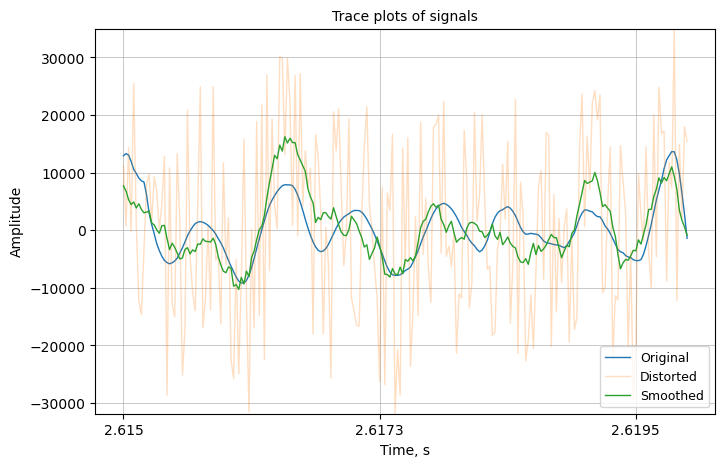

In [20]:
start_time, end_time = 2.615, 2.62 # seconds
start_idx, end_idx = int(start_time * rate), int(max(duration, end_time * rate))
plt.figure(figsize=(8, 5))
plt.plot(t[start_idx: end_idx], signal[start_idx: end_idx], color='C0', lw=1, label='Original')
plt.plot(t[start_idx: end_idx], signal_distorted[start_idx: end_idx], color='C1', lw=1, alpha=0.25, label='Distorted')
plt.plot(t[start_idx: end_idx], signal_smoothed[start_idx: end_idx], color='C2', lw=1, label='Smoothed')
plt.title('Trace plots of signals', size=10)
plt.xlabel('Time, s')
plt.ylabel('Amplitude')
plt.xticks(t[start_idx: end_idx: 100],  np.round(t[start_idx: end_idx: 100] / rate, 4))
plt.ylim([signal_distorted[start_idx: end_idx].min(), signal_distorted[start_idx: end_idx].max()])
plt.legend(loc='lower right', prop={'size': 9})
plt.grid(lw=0.5);

In [9]:
# Apply fast Fourier transform to get spectra of signals
freqs = np.fft.fftfreq(len(t), d=1/SAMPLE_LEN)
fft_original = np.fft.fft(signal)
fft_distorted = np.fft.fft(signal_distorted)
fft_smoothed = np.fft.fft(signal_smoothed)

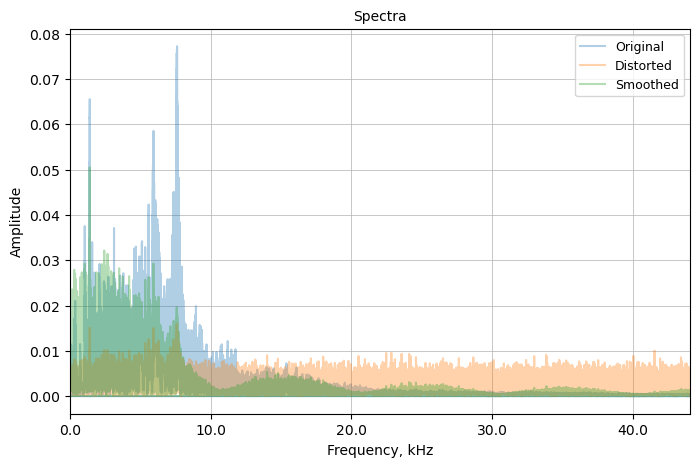

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(freqs, np.abs(fft_original) / np.abs(signal).sum(), color='C0', alpha=0.35, label='Original')
plt.plot(freqs, np.abs(fft_distorted) / np.abs(signal_distorted).sum(), color='C1', alpha=0.35, label='Distorted')
plt.plot(freqs, np.abs(fft_smoothed) / np.abs(signal_smoothed).sum(), color='C2', alpha=0.35, label='Smoothed')
plt.title('Spectra', size=10)
plt.xlabel('Frequency, kHz')
plt.ylabel('Amplitude')
plt.xticks(np.arange(0, rate, 10000), np.arange(0, rate, 10000) / 1000)
plt.xlim([0, rate])
plt.legend(loc='upper right', prop={'size': 9})
plt.grid(lw=0.5);